In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from Bio import pairwise2
from Bio import Seq
import math
import json
import networkx as nx

In [2]:
def _pairwise2_list(list_prev, seq):
    align_score = -math.inf
    best_sequence = ""
    for prev_seq in list_prev:
        current_score = pairwise2.align.localxs(prev_seq, seq, -1, -1, score_only=True)
        if current_score > align_score:
            align_score = current_score
            best_sequence = prev_seq
    return (align_score, best_sequence)

def _multiple_pairwise2(row_prev_seq, list_curr, list_columns):
    align_score = -math.inf
    best_prev = ""
    best_curr = ""
    list_curr = set(list_curr)
    for column in list_columns:
        # quick fix: check if instance of list
        if isinstance(row_prev_seq[column], list):
            list_prev = set(row_prev_seq[column])
            for prev_seq in list_prev:
                for curr_seq in list_curr:
                    current_score = pairwise2.align.globalxs(prev_seq, curr_seq, -1, -1, score_only=True)
                    if current_score > align_score:
                        align_score = current_score
                        best_prev = prev_seq
                        best_curr = curr_seq
    if align_score > -math.inf:
        return (align_score, best_prev, best_curr)
    else:
        return float("NaN")


class HashedAln:
    def __init__(self, ref_clones, clone_ids, kmer_size):
        ## decided which seq to index( one with more seqs)
        self.reference_clones = {k:v for k,v in zip(clone_ids, ref_clones)}
        self._reference_clones_seq = ref_clones
        self.kmer_size = kmer_size
    
    def build_index(self):
        self.index = {}
        for clone_id, seq in self.reference_clones.items():
            kmers = [seq[i:(i + self.kmer_size)] for i in range(0,len(seq), self.kmer_size)]
            for km in kmers:
                if km in self.index:
                    self.index[km].append(clone_id)
                else:
                    self.index[km]=[clone_id]
    
    def _align_clones_hash(self, query_clones):
        aligned_clones = []
        unaligned_clones = []
        for clone in query_clones:
            hits = set()
            kmers = [clone[i:(i + self.kmer_size)] for i in range(0,len(clone), self.kmer_size)]
            for km in kmers:
                if km in self.index:
                    hits.update(self.index[km])
            if len(hits) >0:
                hits_seq = [self.reference_clones[k] for k in hits ]
                aligned_clones.append(_pairwise2_list(hits_seq, clone))
            else:
                unaligned_clones.append(clone)
        return aligned_clones, unaligned_clones
    def _align_clones_pairwise(self, query_clones):
        aligned_clones = [ _pairwise2_list(self._reference_clones_seq, clone ) 
            for clone in query_clones ]
        return aligned_clones
    def align_clones(self, query_clones):
        print("Aligning with hash")
        aligned, unaligned = self._align_clones_hash(query_clones)
        print(f"{len(unaligned)} failed to align with hash, running standard pairwise alignment")
        aligned += self._align_clones_pairwise(unaligned)
        print("Done")
        return aligned
# 

# %%

def regex_matching(ref_clones, ref_ids, query_clones, query_ids):
    algn_score = {key: 0 for key in query_ids} # for each query seq_id, how many 1 mismatch alignment matches
    algn_matches = {} # for each query seq_id, what are the matched pre-clone ids
    ref_clones = {k:v for k,v in zip(ref_ids, ref_clones)}
    query_clones = {k:v for k,v in zip(query_ids, query_clones)}
    for query_id, query_seq in query_clones.items():
        for ref_id, ref_seq in ref_clones.items():
            if regex.search(r'\*', ref_seq) | regex.search(r'\*', query_seq):
                continue
            # regex pattern should be shorter than query 
            # findall returns the matched pattern in query
            if len(query_seq) >= len(ref_seq): #then ref_seq is the pattern
                matches = regex.findall("(%s){s<=1}" % ref_seq, "%s" % query_seq, overlapped=True)
            else:
                matches = regex.findall("(%s){s<=1}" % query_seq, "%s" % ref_seq, overlapped=True)
            if len(matches) > 0:
                algn_score[query_id] += 1
                if query_id in algn_matches:
                    algn_matches[query_id].append(ref_id)
                else:
                    algn_matches[query_id] = [ref_id]
    return algn_score, algn_matches

In [3]:
# JB version:

def _pairwise2_list(list_compare, seq, min_score):
    # align_score = -math.inf
    matching_sequences = []
    for compare_seq in list_compare:
        current_score = pairwise2.align.globalxs(compare_seq, seq, -1, -1, score_only=True)
        if current_score >= min_score:
            matching_sequences.append((current_score, compare_seq))
    return matching_sequences

class HashedAln:
    def __init__(self, ref_clones, clone_ids, kmer_size, num_errors):
        ## decided which seq to index( one with more seqs)
        self.reference_clones = {k:v for k,v in zip(clone_ids, ref_clones)}
        self._reference_clones_seq = ref_clones
        # fix this so that kmer size is prop to length
        self.kmer_size = kmer_size
        self.num_errors = num_errors
    
    def build_index(self):
        self.index = {}
        for clone_id, seq in self.reference_clones.items():
            kmers = [seq[i:(i + self.kmer_size)] for i in range(0,len(seq), self.kmer_size)]
            for km in kmers:
                if km in self.index:
                    self.index[km].append(clone_id)
                else:
                    self.index[km]=[clone_id]
    
    def _align_clones_hash(self, query_clones, query_clone_ids):
        aligned_clones = []
        unaligned_clones = []
        for query_clone_id, clone in zip(query_clone_ids, query_clones):
            hits = set()
            kmers = [clone[i:(i + self.kmer_size)] for i in range(0,len(clone), self.kmer_size)]
            for km in kmers:
                if km in self.index:
                    hits.update(self.index[km])
            hits = [hit for hit in hits if hit != query_clone_id]
            if len(hits) > 0:
                hits_seq = [self.reference_clones[k] for k in hits]
                min_score = len(clone) - self.num_errors
                aligned_clones.append(_pairwise2_list(hits_seq, clone, min_score))
            else:
                aligned_clones.append([])
        return aligned_clones
    
    def _align_clones_pairwise(self, query_clones):
        aligned_clones = [ _pairwise2_list(self._reference_clones_seq, clone, len(clone) - self.num_errors)
            for clone in query_clones ]
        return aligned_clones
    
    def align_clones(self, query_clones, query_clone_ids):
        print("Aligning with hash")
        aligned = self._align_clones_hash(query_clones, query_clone_ids)
        # print(f"{len(unaligned)} failed to align with hash")
        # aligned += self._align_clones_pairwise(unaligned)
        print("Done")
        return aligned

In [21]:
df = pd.read_csv("data/GSE179994/GSE179994_PBMC.bulkTCR.tsv", sep = '\t')
print(df.head())

df = df.assign(clone_nt = df['TRB'].str.extract(r"(_\w+_)").iloc[:,0].str.replace("_", "").tolist())

df = df.assign(clone_aa =  [Seq.translate(i) for i in df.clone_nt.tolist()])

## check cannonicla seqs
df = df[df.clone_aa.str.contains(r"^C")].pipe(lambda x: x[x.clone_aa.str.contains(r"F$")])

##

df_pre = df[df['sample'].str.contains("pre")]
df_post = df[df['sample'].str.contains("post")]

#5817 exact matches 




clones_pre_aa = df_pre[~df_pre.clone_aa.isin(df_post['clone_aa'])]['clone_aa'].tolist()
clones_post_aa = df_post[~df_post.clone_aa.isin(df_pre['clone_aa'])]['clone_aa'].tolist()



clones_pre_ids = df_pre[~df_pre.clone_aa.isin(df_post['clone_aa'])]['cloneId'].tolist()


alnr = HashedAln(clones_pre_aa, clones_pre_ids, 6, 2)

alnr.build_index()

     sample  cloneId  cloneCount  cloneFraction  \
0  P19.post        0       24596       0.036488   
1  P19.post        1       21190       0.031436   
2  P19.post        2       18234       0.027050   
3  P19.post        3       12421       0.018427   
4  P19.post        4        5360       0.007952   

                                                 TRB  
0  TRBV5-1_TGCGCCAGCAGTACGGACGGGAAAGGCTACACCTTC_T...  
1  TRBV5-1_TGCGCCAGCAGCTTGGAGGGGGAAAAAGGCGCTGAAGC...  
2  TRBV5-1_TGCGCCAGCAGTTCTATCGGGACAGATCTTAACTATGG...  
3  TRBV20-1_TGCAGTGCTAGAGACGGACAGGGGAGGATAGTTGAAG...  
4  TRBV20-1_TGCAGTGCCCAGACAGGGGGCGAAAACACAGATACGC...  


/Users/jbreynier/opt/anaconda3/envs/tcr_aligner_env/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [22]:
res = alnr.align_clones(clones_pre_aa[:100])# %%

Aligning with hash
1 failed to align with hash, running standard pairwise alignment
Done


In [11]:
df_pre

,sample,cloneId,cloneCount,cloneFraction,TRB,clone_nt,clone_aa
105214,P19.pre,0,48309,6.513430e-02,TRBV5-1_TGCGCCAGCAGTACGGACGGGAAAGGCTACACCTTC_T...,TGCGCCAGCAGTACGGACGGGAAAGGCTACACCTTC,CASSTDGKGYTF
105215,P19.pre,1,26417,3.561764e-02,TRBV5-1_TGCGCCAGCAGCTTGGAGGGGGAAAAAGGCGCTGAAGC...,TGCGCCAGCAGCTTGGAGGGGGAAAAAGGCGCTGAAGCTTTCTTT,CASSLEGEKGAEAFF
105216,P19.pre,2,19716,2.658279e-02,TRBV20-1_TGCAGTGCTAGAGACGGACAGGGGAGGATAGTTGAAG...,TGCAGTGCTAGAGACGGACAGGGGAGGATAGTTGAAGCTTTCTTT,CSARDGQGRIVEAFF
105217,P19.pre,3,17647,2.379318e-02,TRBV7-2_TGTGCCAGCAGCCTACTAGCTCTTGGCGCTGGGGCCAA...,TGTGCCAGCAGCCTACTAGCTCTTGGCGCTGGGGCCAACGTCCTGA...,CASSLLALGAGANVLTF
105218,P19.pre,4,16761,2.259860e-02,TRBV5-1_TGCGCCAGCAGTTCTATCGGGACAGATCTTAACTATGG...,TGCGCCAGCAGTTCTATCGGGACAGATCTTAACTATGGCTACACCTTC,CASSSIGTDLNYGYTF
...,...,...,...,...,...,...,...
160743,P13.pre,14929,1,6.401446e-07,TRBV20-1_TGCAGTGCTAGCTACGAGCAGTACTTC_TRBJ2-7,TGCAGTGCTAGCTACGAGCAGTACTTC,CSASYEQYF
160744,P13.pre,14930,1,6.401446e-07,TRBV29-1_TGCAGCGTTGGTCCGCCCCAGCATTTT_TRBJ1-5,TGCAGCGTTGGTCCGCCCCAGCATTTT,CSVGPPQHF
160745,P13.pre,14931,1,6.401446e-07,TRBV23-1_TGCGCCAGCAGTCAGAGGTACTTC_TRBJ2-5,TGCGCCAGCAGTCAGAGGTACTTC,CASSQRYF
160746,P13.pre,14932,1,6.401446e-07,TRBV4-1_TGCGCCAGCAGCCCGCCAGCCTTC_TRBJ2-4,TGCGCCAGCAGCCCGCCAGCCTTC,CASSPPAF


In [43]:
res

[[],
 [],
 [],
 [],
 [],
 [],
 [(14.0, 'CASSQDRAASQPQHF')],
 [(11.0, 'CASSPGHGNEQFF'),
  (11.0, 'CASSPTPWDEQFF'),
  (11.0, 'CASSPTHGYEQYF'),
  (11.0, 'CASSPTGGDEQYF')],
 [(13.0, 'CASSRDRANTGELFF'),
  (13.0, 'CASSLDGAVTGELFF'),
  (13.0, 'CASSLDRGANTGELFF'),
  (13.0, 'CASSLERADTGELFF')],
 [],
 [(11.0, 'CASSLAGFNEQYF')],
 [],
 [(8.0, 'CSVGGGEQFF'), (8.0, 'CSAGQGYNEQFF')],
 [(12.0, 'CASSAGAKWDTQYF')],
 [],
 [],
 [],
 [(14.0, 'CASSLALTANTEAFF')],
 [(13.0, 'CASSPRILSYEQYF')],
 [],
 [],
 [(13.0, 'CASSLRGGPSYEQYF'),
  (13.0, 'CASSLSGGAGYEQYF'),
  (13.0, 'CASSLVGSGGYEQYF'),
  (13.0, 'CASSLLGTGGYEQYF'),
  (13.0, 'CASSLKGGGPYEQYF'),
  (13.0, 'CASSVDGGGGYEQYF'),
  (13.0, 'CASSLVGGEGYEQYF'),
  (13.0, 'CASSLAGTGGYEQYF'),
  (13.0, 'CASSLDGGGSYEQYF'),
  (13.0, 'CASSLTGGAGYEQYF')],
 [(12.0, 'CASSLGLAGGGQFF')],
 [],
 [(12.0, 'CSVEGQGPYNEQFF')],
 [(14.0, 'CASSPGLAGLQETQYF')],
 [(13.0, 'CASSPTGSGANVLTF'),
  (13.0, 'CASSRSGPGANVLTF'),
  (13.0, 'CASSPRGSGANVLTF'),
  (13.0, 'CASSREGATGANVLTF'),
  (13.0, 'CAS

In [95]:
df_vdjdb = pd.read_csv("data/vdjdb/SearchTable-2022-01-21 09_44_36.727.tsv", sep="\t")

In [5]:
df_vdjdb

,complex.id,Gene,CDR3,V,J,Species,MHC A,MHC B,MHC class,Epitope,Epitope gene,Epitope species,Reference,Method,Meta,CDR3fix,Score
0,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2
1,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEAGQGFFSNQPQHF"", ""cdr3_old"": ""C...",2
2,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2
3,3,TRB,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYEPGQVSHYSNQPQHF"", ""cdr3_old"": ""...",2
4,4,TRB,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSALASLNEQFF"", ""cdr3_old"": ""CASSAL...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73428,26172,TRA,CAFLNAGGTSYGKLTF,TRAV38-1*01,TRAJ52*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,Spike,SARS-CoV-2,PMID:34086357,"{""frequency"": ""1/11"", ""identification"": ""tetra...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAFLNAGGTSYGKLTF"", ""cdr3_old"": ""CAFL...",1
73429,26173,TRA,CAVYNQGGKLIF,TRAV8-1*01,TRAJ23*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,Spike,SARS-CoV-2,PMID:34086357,"{""frequency"": ""1/11"", ""identification"": ""tetra...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVYNQGGKLIF"", ""cdr3_old"": ""CAVYNQGG...",1
73430,26174,TRA,CAVRALYNFNKFYF,TRAV3*01,TRAJ21*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,Spike,SARS-CoV-2,PMID:34086357,"{""frequency"": ""1/11"", ""identification"": ""tetra...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVRALYNFNKFYF"", ""cdr3_old"": ""CAVRAL...",1
73431,26175,TRA,CAVESYNTDKLIF,TRAV41*01,TRAJ34*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,Spike,SARS-CoV-2,PMID:34086357,"{""frequency"": ""1/11"", ""identification"": ""tetra...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVESYNTDKLIF"", ""cdr3_old"": ""CAVESYN...",1


In [6]:
df_vdjdb_len = df_vdjdb.drop_duplicates(subset="CDR3").loc[:, ["CDR3"]]

In [7]:
df_vdjdb_len["length"] = df_vdjdb_len.apply(lambda x: len(x["CDR3"]), axis=1)

array([[<AxesSubplot:title={'center':'length'}>]], dtype=object)

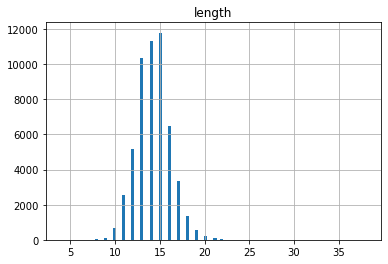

In [8]:
df_vdjdb_len.hist("length", bins=100)

Choose only amino acids with length > 12 (easier to compute, use kmer of 6)

In [9]:
df_vdjdb_len = df_vdjdb_len.loc[df_vdjdb_len["length"] >= 12,:]
df_vdjdb_len = df_vdjdb_len.reset_index(drop=True)
df_vdjdb_len["id"] = df_vdjdb_len.index

array([[<AxesSubplot:title={'center':'length'}>]], dtype=object)

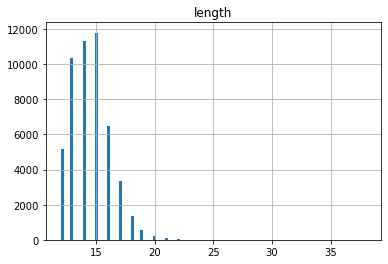

In [10]:
df_vdjdb_len.hist("length", bins=100)

In [11]:
len(df_vdjdb_len)

50726

In [14]:
aligner_vdjdb = HashedAln(df_vdjdb_len["CDR3"].to_list(), df_vdjdb_len["id"].to_list(), 6, 1)
aligner_vdjdb.build_index()

In [13]:
vdjdb_alignments = aligner_vdjdb.align_clones(df_vdjdb_len["CDR3"].to_list(), df_vdjdb_len["id"].to_list())

Aligning with hash
Done


In [15]:
len(vdjdb_alignments)

50726

In [16]:
df_vdjdb_results = pd.DataFrame({"CDR3": df_vdjdb_len["CDR3"].to_list(), "cdr3_alignments": vdjdb_alignments})

In [17]:
df_vdjdb_results

,CDR3,cdr3_alignments
0,CASSYLPGQGDHYSNQPQHF,[]
1,CASSFEAGQGFFSNQPQHF,[]
2,CASSFEPGQGFYSNQPQHF,[]
3,CASSYEPGQVSHYSNQPQHF,[]
4,CASSALASLNEQFF,[]
...,...,...
50721,CAVRHTNAGKSTF,"[(12.0, CAVRDTNAGKSTF)]"
50722,CAFLNAGGTSYGKLTF,"[(15.0, CAFFNAGGTSYGKLTF), (15.0, CAPLNAGGTSYG..."
50723,CAVRALYNFNKFYF,"[(13.0, CAVRGLYNFNKFYF)]"
50724,CAVESYNTDKLIF,"[(12.0, CAVGSYNTDKLIF), (12.0, CAVSSYNTDKLIF),..."


In [18]:
df_vdjdb_results = df_vdjdb_results.explode('cdr3_alignments').reset_index(drop=True)

In [19]:
df_vdjdb_results = df_vdjdb_results.dropna()
df_vdjdb_results["cdr3_alignments"] = df_vdjdb_results["cdr3_alignments"].apply(lambda x: x[1])
df_vdjdb_results

,CDR3,cdr3_alignments
5,CASSFGVEDEQYF,CASNFGVEDEQYF
6,CASSFGVEDEQYF,CASSLGVEDEQYF
7,CASSIRSTDTQYF,CASSVRSTDTQYF
8,CASSIRSTDTQYF,CASSPRSTDTQYF
9,CASSIRSTDTQYF,CASSTRSTDTQYF
...,...,...
90512,CAVESYNTDKLIF,CAVASYNTDKLIF
90513,CAVESYNTDKLIF,CAVISYNTDKLIF
90514,CAVESYNTDKLIF,CAVPSYNTDKLIF
90515,CAMREGQGNAGNMLTF,CAMREGIGNAGNMLTF


In [20]:
df_vdjdb_results.to_csv("vdjdb_cdr3_alignments_all.csv", index=False)

In [23]:
df_vdjdb_noduplicates = pd.DataFrame(np.sort(df_vdjdb_results[["CDR3", "cdr3_alignments"]],1),
                                    index=df_vdjdb_results.index, 
                                    columns=["cdr3_1", "cdr3_2"]).drop_duplicates()

In [24]:
df_vdjdb_noduplicates

,cdr3_1,cdr3_2
5,CASNFGVEDEQYF,CASSFGVEDEQYF
6,CASSFGVEDEQYF,CASSLGVEDEQYF
7,CASSIRSTDTQYF,CASSVRSTDTQYF
8,CASSIRSTDTQYF,CASSPRSTDTQYF
9,CASSIRSTDTQYF,CASSTRSTDTQYF
...,...,...
90276,CAANTEGADRLTF,CAAYTEGADRLTF
90281,CAVSMDYSNNRLTLF,CAVSTDYSNNRLTLF
90289,CAASEGSNYNVLYF,CAASMGSNYNVLYF
90361,CAVNDYGQNFVF,CAVSDYGQNFVF


In [26]:
df_vdjdb_noduplicates = df_vdjdb_noduplicates.loc[df_vdjdb_noduplicates["cdr3_1"].str.len() == df_vdjdb_noduplicates["cdr3_2"].str.len(), :]

In [27]:
def get_changed_aa(row):
    # Loop over the indices of the string
    error = []
    cdr3_1 = row["cdr3_1"]
    cdr3_2 = row["cdr3_2"]
    for i in range(len(cdr3_1)):
        if cdr3_1[i] != cdr3_2[i]:
            error = [cdr3_1[i], cdr3_2[i]]
            break
    return error

In [29]:
df_vdjdb_noduplicates.loc[:, "change"] = df_vdjdb_noduplicates.apply(get_changed_aa, axis=1)

/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_16623/2184953752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vdjdb_noduplicates.loc[:, "change"] = df_vdjdb_noduplicates.apply(get_changed_aa, axis=1)


In [30]:
df_vdjdb_noduplicates

,cdr3_1,cdr3_2,change
5,CASNFGVEDEQYF,CASSFGVEDEQYF,"[N, S]"
6,CASSFGVEDEQYF,CASSLGVEDEQYF,"[F, L]"
7,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]"
8,CASSIRSTDTQYF,CASSPRSTDTQYF,"[I, P]"
9,CASSIRSTDTQYF,CASSTRSTDTQYF,"[I, T]"
...,...,...,...
90276,CAANTEGADRLTF,CAAYTEGADRLTF,"[N, Y]"
90281,CAVSMDYSNNRLTLF,CAVSTDYSNNRLTLF,"[M, T]"
90289,CAASEGSNYNVLYF,CAASMGSNYNVLYF,"[E, M]"
90361,CAVNDYGQNFVF,CAVSDYGQNFVF,"[N, S]"


In [32]:
df_vdjdb_antigens = df_vdjdb.drop_duplicates(subset=["CDR3", "Epitope"]).loc[:, ["CDR3", "Epitope"]]
df_vdjdb_antigens

,CDR3,Epitope
0,CASSYLPGQGDHYSNQPQHF,FLKEKGGL
1,CASSFEAGQGFFSNQPQHF,FLKEKGGL
2,CASSFEPGQGFYSNQPQHF,FLKEKGGL
3,CASSYEPGQVSHYSNQPQHF,FLKEKGGL
4,CASSALASLNEQFF,FLKEKGGL
...,...,...
73428,CAFLNAGGTSYGKLTF,QYIKWPWYI
73429,CAVYNQGGKLIF,QYIKWPWYI
73430,CAVRALYNFNKFYF,QYIKWPWYI
73431,CAVESYNTDKLIF,QYIKWPWYI


In [33]:
df_blosum_matrix = pd.read_csv("data/BLOSUM62.csv")
df_blosum_matrix

,A,R,N,D,C,Q,E,G,H,I,...,P,S,T,W,Y,V,B,Z,X,*
A,4,-1,-2,-2,0,-1,-1,0,-2,-1,...,-1,1,0,-3,-2,0,-2,-1,0,-4
R,-1,5,0,-2,-3,1,0,-2,0,-3,...,-2,-1,-1,-3,-2,-3,-1,0,-1,-4
N,-2,0,6,1,-3,0,0,0,1,-3,...,-2,1,0,-4,-2,-3,3,0,-1,-4
D,-2,-2,1,6,-3,0,2,-1,-1,-3,...,-1,0,-1,-4,-3,-3,4,1,-1,-4
C,0,-3,-3,-3,9,-3,-4,-3,-3,-1,...,-3,-1,-1,-2,-2,-1,-3,-3,-2,-4
Q,-1,1,0,0,-3,5,2,-2,0,-3,...,-1,0,-1,-2,-1,-2,0,3,-1,-4
E,-1,0,0,2,-4,2,5,-2,0,-3,...,-1,0,-1,-3,-2,-2,1,4,-1,-4
G,0,-2,0,-1,-3,-2,-2,6,-2,-4,...,-2,0,-2,-2,-3,-3,-1,-2,-1,-4
H,-2,0,1,-1,-3,0,0,-2,8,-3,...,-2,-1,-2,-2,2,-3,0,0,-1,-4
I,-1,-3,-3,-3,-1,-3,-3,-4,-3,4,...,-3,-2,-1,-3,-1,3,-3,-3,-1,-4


In [34]:
df_vdjdb_noduplicates_antigen = df_vdjdb_noduplicates.merge(df_vdjdb_antigens, how="left", left_on="cdr3_1", right_on="CDR3")
df_vdjdb_noduplicates_antigen = df_vdjdb_noduplicates_antigen.drop(columns="CDR3")
df_vdjdb_noduplicates_antigen = df_vdjdb_noduplicates_antigen.rename(columns={"Epitope": "epitope_1"})
df_vdjdb_noduplicates_antigen = df_vdjdb_noduplicates_antigen.merge(df_vdjdb_antigens, how="left", left_on="cdr3_2", right_on="CDR3")
df_vdjdb_noduplicates_antigen = df_vdjdb_noduplicates_antigen.drop(columns="CDR3")
df_vdjdb_noduplicates_antigen = df_vdjdb_noduplicates_antigen.rename(columns={"Epitope": "epitope_2"})

In [35]:
df_vdjdb_noduplicates_antigen

,cdr3_1,cdr3_2,change,epitope_1,epitope_2
0,CASNFGVEDEQYF,CASSFGVEDEQYF,"[N, S]",LQPFPQPELPYPQPQ,LQPFPQPELPYPQPQ
1,CASSFGVEDEQYF,CASSLGVEDEQYF,"[F, L]",LQPFPQPELPYPQPQ,LQPFPQPELPYPQPQ
2,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",LQPFPQPELPYPQPQ,APQPELPYPQPG
3,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",LQPFPQPELPYPQPQ,GILGFVFTL
4,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",GILGFVFTL,APQPELPYPQPG
...,...,...,...,...,...
43257,CAANTEGADRLTF,CAAYTEGADRLTF,"[N, Y]",KAVYNFATC,KAVYNFATC
43258,CAVSMDYSNNRLTLF,CAVSTDYSNNRLTLF,"[M, T]",KAVYNFATC,KAVYNFATC
43259,CAASEGSNYNVLYF,CAASMGSNYNVLYF,"[E, M]",KAVYNFATC,KAVYNFATC
43260,CAVNDYGQNFVF,CAVSDYGQNFVF,"[N, S]",QIKVRVDMV,QIKVRVDMV


In [36]:
def get_substitution_score(row):
    return df_blosum_matrix.loc[row["change"][0], row["change"][1]]

In [37]:
df_vdjdb_noduplicates_sameantigen = df_vdjdb_noduplicates_antigen.loc[df_vdjdb_noduplicates_antigen["epitope_1"] == df_vdjdb_noduplicates_antigen["epitope_2"], :]
df_vdjdb_noduplicates_sameantigen["substitution_score"] = df_vdjdb_noduplicates_sameantigen.apply(get_substitution_score, axis=1)

/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_16623/204865549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vdjdb_noduplicates_sameantigen["substitution_score"] = df_vdjdb_noduplicates_sameantigen.apply(get_substitution_score, axis=1)


In [64]:
print(df_vdjdb_noduplicates_sameantigen["substitution_score"].mean())
print(df_vdjdb_noduplicates_sameantigen["substitution_score"].sem())

-0.9723618090452262
0.011723798558741803


In [39]:
df_vdjdb_noduplicates_diffantigen = df_vdjdb_noduplicates_antigen.loc[df_vdjdb_noduplicates_antigen["epitope_1"] != df_vdjdb_noduplicates_antigen["epitope_2"], :]
df_vdjdb_noduplicates_diffantigen["substitution_score"] = df_vdjdb_noduplicates_diffantigen.apply(get_substitution_score, axis=1)

/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_16623/3116461102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vdjdb_noduplicates_diffantigen["substitution_score"] = df_vdjdb_noduplicates_diffantigen.apply(get_substitution_score, axis=1)


-1.1233009708737864

In [62]:
print(df_vdjdb_noduplicates_diffantigen["substitution_score"].mean())
print(df_vdjdb_noduplicates_diffantigen["substitution_score"].sem())

-1.1233009708737864
0.00941327510107694


In [40]:
df_vdjdb_noduplicates_diffantigen

,cdr3_1,cdr3_2,change,epitope_1,epitope_2,substitution_score
2,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",LQPFPQPELPYPQPQ,APQPELPYPQPG,3
3,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",LQPFPQPELPYPQPQ,GILGFVFTL,3
4,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",GILGFVFTL,APQPELPYPQPG,3
6,CASSIRSTDTQYF,CASSPRSTDTQYF,"[I, P]",LQPFPQPELPYPQPQ,GILGFVFTL,-3
7,CASSIRSTDTQYF,CASSPRSTDTQYF,"[I, P]",LQPFPQPELPYPQPQ,AVFDRKSDAK,-3
...,...,...,...,...,...,...
43245,CAMRGRTGNQFYF,CAMRGSTGNQFYF,"[R, S]",ALSKGVHFV,NYNYLYRLF,-1
43246,CALTNAGGTSYGKLTF,CAPTNAGGTSYGKLTF,"[L, P]",LTDEMIAQY,VYIGDPAQL,-3
43247,CAADNAGNMLTF,CAIDNAGNMLTF,"[A, I]",DTDFVNEFY,LLWNGPMAV,-1
43248,CAANSGNTPLVF,CAARSGNTPLVF,"[N, R]",RYGSFSVTL,QYIKWPWYI,0


In [41]:
df_vdjdb_noduplicates_sameantigen

,cdr3_1,cdr3_2,change,epitope_1,epitope_2,substitution_score
0,CASNFGVEDEQYF,CASSFGVEDEQYF,"[N, S]",LQPFPQPELPYPQPQ,LQPFPQPELPYPQPQ,1
1,CASSFGVEDEQYF,CASSLGVEDEQYF,"[F, L]",LQPFPQPELPYPQPQ,LQPFPQPELPYPQPQ,0
5,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",GILGFVFTL,GILGFVFTL,3
8,CASSIRSTDTQYF,CASSPRSTDTQYF,"[I, P]",GILGFVFTL,GILGFVFTL,-3
11,CASSIRSTDTQYF,CASSTRSTDTQYF,"[I, T]",GILGFVFTL,GILGFVFTL,-1
...,...,...,...,...,...,...
43257,CAANTEGADRLTF,CAAYTEGADRLTF,"[N, Y]",KAVYNFATC,KAVYNFATC,-2
43258,CAVSMDYSNNRLTLF,CAVSTDYSNNRLTLF,"[M, T]",KAVYNFATC,KAVYNFATC,-1
43259,CAASEGSNYNVLYF,CAASMGSNYNVLYF,"[E, M]",KAVYNFATC,KAVYNFATC,-2
43260,CAVNDYGQNFVF,CAVSDYGQNFVF,"[N, S]",QIKVRVDMV,QIKVRVDMV,1


In [48]:
df_antigenpairs = pd.DataFrame(np.sort(df_vdjdb_noduplicates_antigen[["epitope_1", "epitope_2"]],1),
                                    index=df_vdjdb_noduplicates_antigen.index, 
                                    columns=["epitope_1", "epitope_2"]).drop_duplicates()
df_antigenpairs = df_antigenpairs.loc[df_antigenpairs["epitope_1"] != df_antigenpairs["epitope_2"],:]

In [49]:
df_antigenpairs

,epitope_1,epitope_2
2,APQPELPYPQPG,LQPFPQPELPYPQPQ
3,GILGFVFTL,LQPFPQPELPYPQPQ
4,APQPELPYPQPG,GILGFVFTL
7,AVFDRKSDAK,LQPFPQPELPYPQPQ
9,AVFDRKSDAK,GILGFVFTL
...,...,...
43245,ALSKGVHFV,NYNYLYRLF
43246,LTDEMIAQY,VYIGDPAQL
43247,DTDFVNEFY,LLWNGPMAV
43248,QYIKWPWYI,RYGSFSVTL


In [54]:
df_vdjdb_noduplicates_diffantigen_nooverlap = pd.DataFrame({"cdr3_1": [], "cdr3_2": [],
                                                            "change": [], "epitope_1": [], "epitope_2": []})

for _, row in df_antigenpairs.iterrows():
    df_antigen1 = pd.concat([df_vdjdb_noduplicates_antigen.loc[df_vdjdb_noduplicates_antigen["epitope_1"] == row["epitope_1"],["cdr3_1"]].rename(columns={"cdr3_1": "cdr3"}),
                                                        df_vdjdb_noduplicates_antigen.loc[df_vdjdb_noduplicates_antigen["epitope_2"] == row["epitope_1"],["cdr3_2"]].rename(columns={"cdr3_2": "cdr3"})])
    df_antigen2 = pd.concat([df_vdjdb_noduplicates_antigen.loc[df_vdjdb_noduplicates_antigen["epitope_1"] == row["epitope_2"],["cdr3_1"]].rename(columns={"cdr3_1": "cdr3"}),
                                                        df_vdjdb_noduplicates_antigen.loc[df_vdjdb_noduplicates_antigen["epitope_2"] == row["epitope_2"],["cdr3_2"]].rename(columns={"cdr3_2": "cdr3"})])
    if len(df_antigen1.merge(df_antigen2, how="inner")) == 0:
        df_vdjdb_noduplicates_paired_antigen = pd.concat([df_vdjdb_noduplicates_antigen.loc[(df_vdjdb_noduplicates_antigen["epitope_1"] == row["epitope_1"]) & (df_vdjdb_noduplicates_antigen["epitope_2"] == row["epitope_2"]),:],
                                                        df_vdjdb_noduplicates_antigen.loc[(df_vdjdb_noduplicates_antigen["epitope_1"] == row["epitope_2"]) & (df_vdjdb_noduplicates_antigen["epitope_2"] == row["epitope_1"]),:]])
        df_vdjdb_noduplicates_diffantigen_nooverlap = pd.concat([df_vdjdb_noduplicates_diffantigen_nooverlap, df_vdjdb_noduplicates_paired_antigen])

In [63]:
df_vdjdb_noduplicates_diffantigen_nooverlap["substitution_score"] = df_vdjdb_noduplicates_diffantigen_nooverlap.apply(get_substitution_score, axis=1)
print(df_vdjdb_noduplicates_diffantigen_nooverlap["substitution_score"].mean())
print(df_vdjdb_noduplicates_diffantigen_nooverlap["substitution_score"].sem())

-1.2235349716446124
0.022616150435448727


In [68]:
means = [df_vdjdb_noduplicates_sameantigen["substitution_score"].mean(),
                    df_vdjdb_noduplicates_diffantigen["substitution_score"].mean(),
                    df_vdjdb_noduplicates_diffantigen_nooverlap["substitution_score"].mean()]
means = [-1 * mean for mean in means]

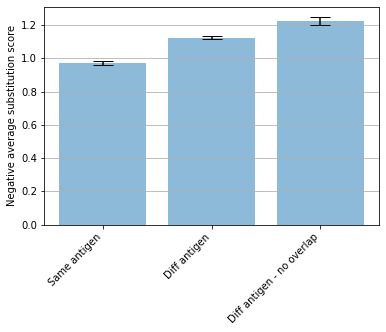

In [78]:
standard_errors = [df_vdjdb_noduplicates_sameantigen["substitution_score"].sem(),
                    df_vdjdb_noduplicates_diffantigen["substitution_score"].sem(),
                    df_vdjdb_noduplicates_diffantigen_nooverlap["substitution_score"].sem()]

# means = [df_vdjdb_noduplicates_sameantigen["substitution_score"].mean(),
#                     df_vdjdb_noduplicates_diffantigen["substitution_score"].mean(),
#                     df_vdjdb_noduplicates_diffantigen_nooverlap["substitution_score"].mean()]
methods_x = [1, 2, 3]
methods = ["Same antigen", "Diff antigen", "Diff antigen - no overlap"]

fig, ax = plt.subplots()
ax.bar(methods_x, means, yerr=standard_errors, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Negative average substitution score')
ax.set_xticks(methods_x)
plt.xticks(rotation = 45, ha="right")
ax.set_xticklabels(methods)
ax.yaxis.grid(True)
plt.savefig('substitution_score_cdr3.jpg', dpi=300, bbox_inches = "tight")
plt.show()

In [90]:
df_vdjdb

,complex.id,Gene,CDR3,V,J,Species,MHC A,MHC B,MHC class,Epitope,Epitope gene,Epitope species,Reference,Method,Meta,CDR3fix,Score
0,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2
1,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEAGQGFFSNQPQHF"", ""cdr3_old"": ""C...",2
2,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2
3,3,TRB,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYEPGQVSHYSNQPQHF"", ""cdr3_old"": ""...",2
4,4,TRB,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSALASLNEQFF"", ""cdr3_old"": ""CASSAL...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73428,26172,TRA,CAFLNAGGTSYGKLTF,TRAV38-1*01,TRAJ52*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,Spike,SARS-CoV-2,PMID:34086357,"{""frequency"": ""1/11"", ""identification"": ""tetra...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAFLNAGGTSYGKLTF"", ""cdr3_old"": ""CAFL...",1
73429,26173,TRA,CAVYNQGGKLIF,TRAV8-1*01,TRAJ23*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,Spike,SARS-CoV-2,PMID:34086357,"{""frequency"": ""1/11"", ""identification"": ""tetra...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVYNQGGKLIF"", ""cdr3_old"": ""CAVYNQGG...",1
73430,26174,TRA,CAVRALYNFNKFYF,TRAV3*01,TRAJ21*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,Spike,SARS-CoV-2,PMID:34086357,"{""frequency"": ""1/11"", ""identification"": ""tetra...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVRALYNFNKFYF"", ""cdr3_old"": ""CAVRAL...",1
73431,26175,TRA,CAVESYNTDKLIF,TRAV41*01,TRAJ34*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,Spike,SARS-CoV-2,PMID:34086357,"{""frequency"": ""1/11"", ""identification"": ""tetra...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVESYNTDKLIF"", ""cdr3_old"": ""CAVESYN...",1


In [98]:
df_vdjdb_score = df_vdjdb.drop_duplicates(subset=["CDR3", "Epitope", "Score"]).loc[:, ["CDR3", "Epitope", "Score"]]
df_vdjdb_score

,CDR3,Epitope,Score
0,CASSYLPGQGDHYSNQPQHF,FLKEKGGL,2
1,CASSFEAGQGFFSNQPQHF,FLKEKGGL,2
2,CASSFEPGQGFYSNQPQHF,FLKEKGGL,2
3,CASSYEPGQVSHYSNQPQHF,FLKEKGGL,2
4,CASSALASLNEQFF,FLKEKGGL,2
...,...,...,...
73428,CAFLNAGGTSYGKLTF,QYIKWPWYI,1
73429,CAVYNQGGKLIF,QYIKWPWYI,1
73430,CAVRALYNFNKFYF,QYIKWPWYI,1
73431,CAVESYNTDKLIF,QYIKWPWYI,1


In [106]:
df_score = pd.DataFrame(df_vdjdb_score.groupby(["CDR3", "Epitope"])["Score"].mean().reset_index())

In [107]:
df_score

,CDR3,Epitope,Score
0,CAAAAGNTGKLIF,HGIRNASFI,0.0
1,CAAAASGGSYIPTF,EPLPQGQLTAY,3.0
2,CAAAAYNQGGKLIF,KLGGALQAK,0.0
3,CAAADDKIIF,LLWNGPMAV,0.0
4,CAAADEEIGNQPQHF,ATDALMTGY,1.0
...,...,...,...
59210,CYSTWRLSCLLLCRDSAGAGSYQLTF,KLGGALQAK,0.0
59211,GDEAGTALIF,PKYVKQNTLKLAT,0.0
59212,LKENTGFQKLVF,GILGFVFTL,0.0
59213,SSGNQFYF,NLVPMVATV,3.0


In [110]:
df_vdjdb_noduplicates_sameantigen

,cdr3_1,cdr3_2,change,epitope_1,epitope_2,substitution_score
0,CASNFGVEDEQYF,CASSFGVEDEQYF,"[N, S]",LQPFPQPELPYPQPQ,LQPFPQPELPYPQPQ,1
1,CASSFGVEDEQYF,CASSLGVEDEQYF,"[F, L]",LQPFPQPELPYPQPQ,LQPFPQPELPYPQPQ,0
5,CASSIRSTDTQYF,CASSVRSTDTQYF,"[I, V]",GILGFVFTL,GILGFVFTL,3
8,CASSIRSTDTQYF,CASSPRSTDTQYF,"[I, P]",GILGFVFTL,GILGFVFTL,-3
11,CASSIRSTDTQYF,CASSTRSTDTQYF,"[I, T]",GILGFVFTL,GILGFVFTL,-1
...,...,...,...,...,...,...
43257,CAANTEGADRLTF,CAAYTEGADRLTF,"[N, Y]",KAVYNFATC,KAVYNFATC,-2
43258,CAVSMDYSNNRLTLF,CAVSTDYSNNRLTLF,"[M, T]",KAVYNFATC,KAVYNFATC,-1
43259,CAASEGSNYNVLYF,CAASMGSNYNVLYF,"[E, M]",KAVYNFATC,KAVYNFATC,-2
43260,CAVNDYGQNFVF,CAVSDYGQNFVF,"[N, S]",QIKVRVDMV,QIKVRVDMV,1


In [115]:
df_vdjdb_noduplicates_sameantigen["epitope_1"].value_counts()

KLGGALQAK         7046
GILGFVFTL         4008
SSYRRPVGI          701
TTPESANL           650
NLVPMVATV          488
                  ... 
YILKYSVFL            1
RFYKTLRAEQASQ        1
RLRPGGRKR            1
SGPLKAEIAQRLED       1
SPRWYFYYL            1
Name: epitope_1, Length: 132, dtype: int64

In [154]:
best_score_simulated = []
rest_score_simulated = []
best_score_sameantigen = []
rest_score_sameantigen = []

for epitope in df_vdjdb_noduplicates_sameantigen["epitope_1"].unique():
    graph_epitope = nx.from_pandas_edgelist(df_vdjdb_noduplicates_sameantigen[df_vdjdb_noduplicates_sameantigen['epitope_1'] == epitope], source='cdr3_1', target='cdr3_2')
    list_graphs = list(nx.connected_components(graph_epitope))
    for group in list_graphs:
        group = list(group)
        if len(group) > 1:
            subset_score = df_score.loc[(df_score["CDR3"].isin(group)) & (df_score["Epitope"] == epitope), :]
            subset_score = subset_score.sort_values(by=["Score"], ascending=False)
            best_score_sameantigen.append(subset_score.iloc[0,2])
            rest_score_sameantigen.append(subset_score.iloc[1:,2].mean())
            df_score = df_score.sample(frac=1)
            subset_score = df_score.iloc[:len(group), :]
            subset_score = subset_score.sort_values(by=["Score"], ascending=False)
            best_score_simulated.append(subset_score.iloc[0,2])
            rest_score_simulated.append(subset_score.iloc[1:,2].mean())

In [147]:
print(len(rest_score_simulated))

2807


In [148]:
np.mean(np.array(rest_score_simulated))

0.015113727659519283

In [150]:
np.mean(np.array(best_score_simulated))

0.41883386771167314

In [149]:
np.mean(np.array(rest_score_sameantigen))

0.10295693482158016

In [151]:
np.mean(np.array(best_score_sameantigen))

0.30572378577366105

In [145]:
print(best_score_sameantigen)

[3.0, 1.0, 3.0, 3.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 3.0, 3.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]


In [144]:
print(best_score_simulated)

[3.0, 3.0, 1.0, 0.0, 3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 0.5, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.5, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 1.0, 3.0, 3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


In [121]:
nx.connected_components(graph_epitope)

<generator object connected_components at 0x7fa9f77e99e0>

In [94]:
df_vdjdb.columns

Index(['complex.id', 'Gene', 'CDR3', 'V', 'J', 'Species', 'MHC A', 'MHC B',
       'MHC class', 'Epitope', 'Epitope gene', 'Epitope species', 'Reference',
       'Method', 'Meta', 'CDR3fix', 'Score', 'cell.subset', 'clone.id',
       'donor.MHC', 'donor.MHC.method', 'epitope.id', 'replica.id',
       'samples.found', 'structure.id', 'studies.found', 'study.id',
       'subject.cohort', 'subject.id', 'tissue'],
      dtype='object')